In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.cluster import KMeans
from skimage import morphology

In [2]:
%matplotlib inline

In [3]:
class Slice:
    def __init__(self, name, greys, densities, points, means):
        self.image = name + ".tif"
        self.label = name + "_label.tif"
        self.skel = name + "_skel.tif"
        self.greys = greys
        self.densities = densities
        self.points = points
        self.means = means

In [4]:
RS0030 = Slice(name="calcification/RS0030_1_yz",
               greys=[49355.9941176471, 44104.6882352941, 39821.1352941176, 32732.8294117647, 26064.9705882353, 21192.1588235294],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[1140, 164], [1320, 164]],
               means=2)

RS0116 = Slice(name="calcification/RS0116_0414",
               greys=[42451.8791946309, 38889.6577181208, 35743.7852348993, 30638.1208053691, 25961.932885906, 23126.5771812081],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[1355, 1334], [1474, 1437]],
               means=2)

RS0128 = Slice(name="calcification/RS0128_yz_451",
               greys=[36217.5648854962, 32658.786259542, 29625.2824427481, 24806.0534351145, 20296.3053435114, 17492.6106870229],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[630, 346], [648, 244]],
               means=1)

RS0130 = Slice(name="calcification/RS0130_xz_820",
               greys=[52215.6940298507, 46477.0597014925, 41837.8805970149, 33930.3059701493, 26430.5820895522, 22135.1791044776],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[503, 1455], [607, 1337]],
               means=2)

In [5]:
s = RS0130

In [6]:
# Read in image and label
image = cv.imread(s.image, -1)
label = cv.imread(s.label, -1)

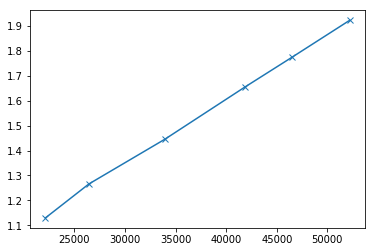

In [7]:
plt.plot(s.greys, s.densities, marker="x")

In [8]:
def quad(x, a, b, c):
    return a * (x ** 2) + (b * x) + c

params, params_covariance = optimize.curve_fit(quad, s.greys, s.densities)

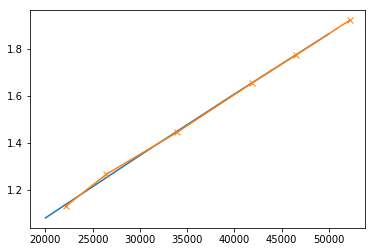

In [9]:
fake = [50000, 40000, 30000, 20000]

guesses = [quad(fake[i], params[0], params[1], params[2]) for i in range(len(fake))]

plt.plot(fake, guesses)
plt.plot(s.greys, s.densities, marker="x")

(array([1.720000e+02, 5.612200e+04, 1.895976e+06, 5.814550e+05,
        3.423200e+04, 8.429000e+03, 5.359000e+03, 4.230000e+03,
        2.246000e+03, 2.053000e+03, 4.383000e+03, 1.088600e+04,
        2.262500e+04, 3.596500e+04, 4.761300e+04, 5.351200e+04,
        5.256900e+04, 4.567200e+04, 3.290500e+04, 1.968500e+04,
        9.869000e+03, 4.362000e+03, 1.694000e+03, 6.260000e+02,
        2.380000e+02, 9.800000e+01, 5.200000e+01, 2.100000e+01,
        8.000000e+00, 3.000000e+00]),
 array([0.63263408, 0.65328014, 0.67392621, 0.69457227, 0.71521834,
        0.7358644 , 0.75651047, 0.77715653, 0.7978026 , 0.81844866,
        0.83909473, 0.85974079, 0.88038686, 0.90103292, 0.92167899,
        0.94232505, 0.96297112, 0.98361718, 1.00426325, 1.02490931,
        1.04555538, 1.06620144, 1.08684751, 1.10749357, 1.12813964,
        1.1487857 , 1.16943177, 1.19007783, 1.2107239 , 1.23136996,
        1.25201603]),
 <a list of 30 Patch objects>)

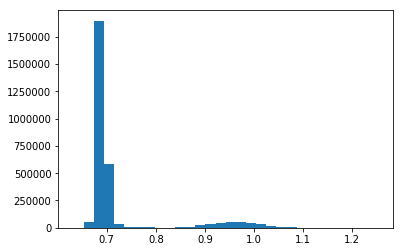

In [10]:
# Calculate densities of all pixels in the image
image_densities = np.zeros(image.shape)

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        image_densities[y, x] = quad(image[y, x], *params)

plt.hist(image_densities.flatten(), bins=30)

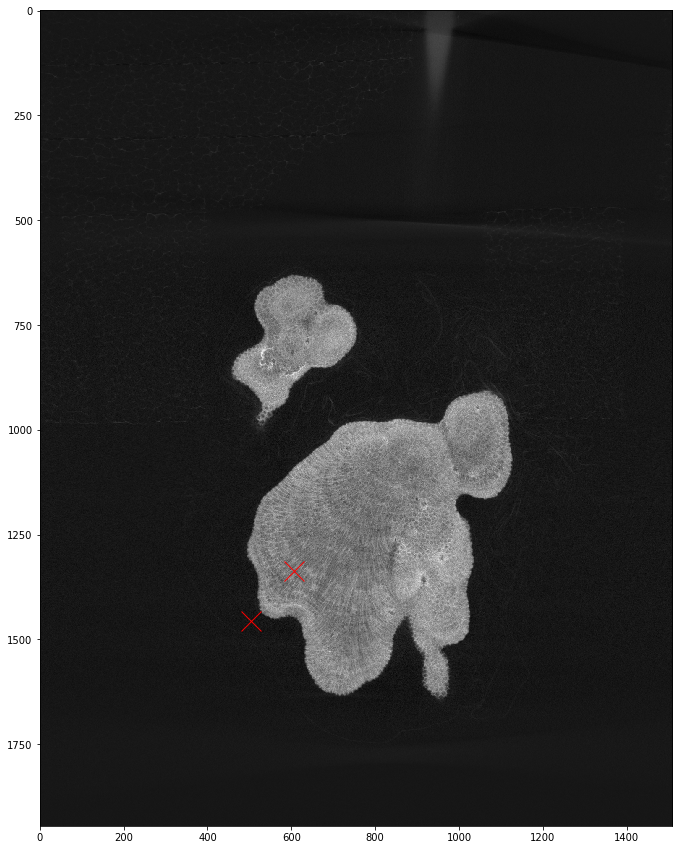

In [11]:
# 204, 1031
# 343, 1244

fig, ax = plt.subplots(figsize=(15,15))

a, b = s.points

ax.imshow(image, cmap="gray")
ax.plot(a[0], a[1], marker="x", markersize=20, color="red")
ax.plot(b[0], b[1], marker="x", markersize=20, color="red")

plt.show()

In [12]:
def center_point(x, y):
    return [(x[0] + y[0]) / 2, (x[1] + y[1]) / 2]

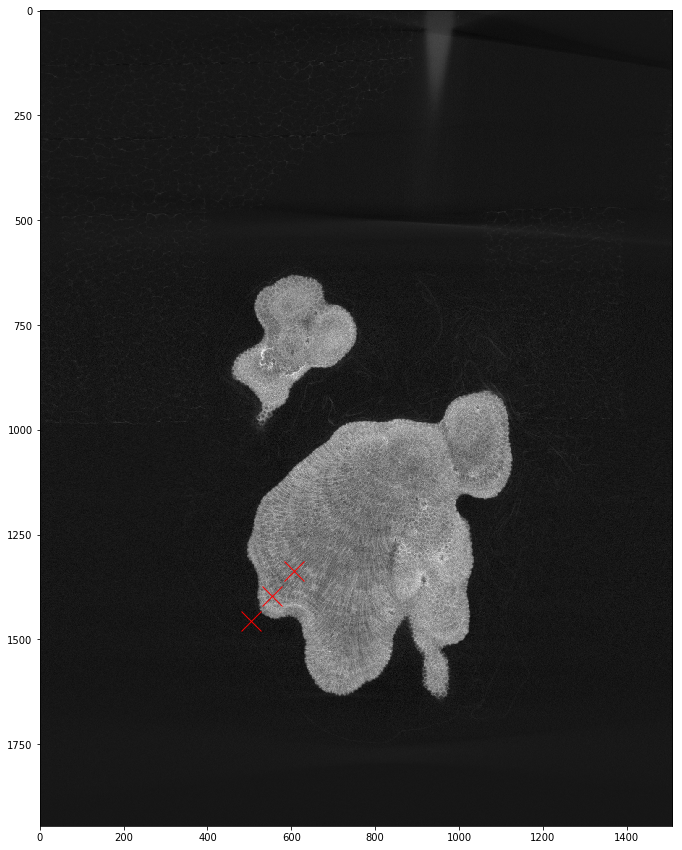

In [13]:
fig, ax = plt.subplots(figsize=(15,15))

c = center_point(a, b)

ax.imshow(image, cmap="gray")
ax.plot(a[0], a[1], marker="x", markersize=20, color="red")
ax.plot(b[0], b[1], marker="x", markersize=20, color="red")
ax.plot(c[0], c[1], marker="x", markersize=20, color="red")

plt.show()

In [14]:
tangent = [b[1] - a[1], b[0] - a[0]]

In [15]:
# Find angle between thge line drawn by the two points and the x axis
angle_r = np.arctan2(*tangent)
angle_d = np.degrees(angle_r)
print(angle_d)

-48.60846885256635


In [16]:
# Rotate a point around an origin point by a given angle
def rotate(p, origin=(0, 0), angle=0):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

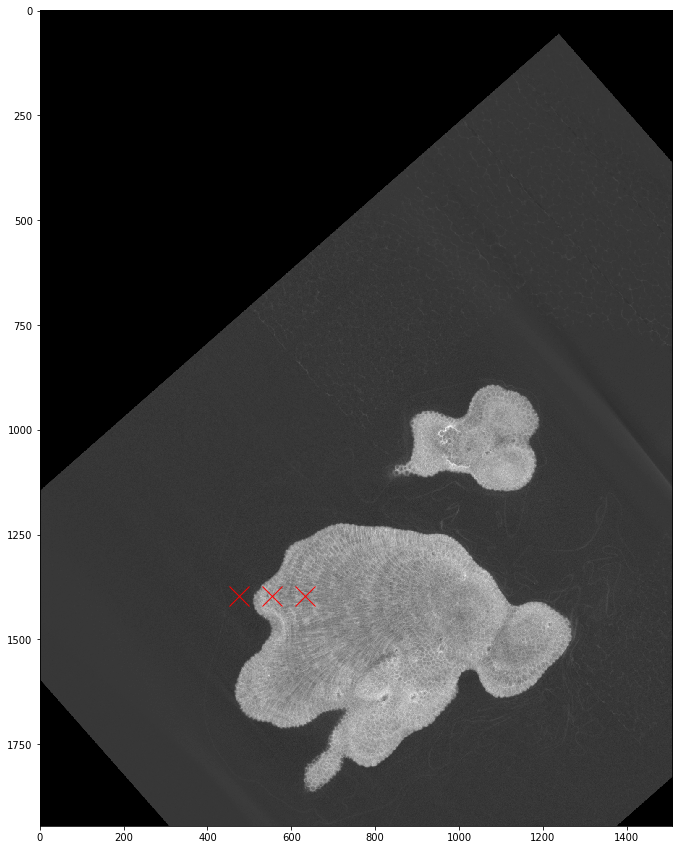

In [17]:
# Rotate the image around the central point
matrix = cv.getRotationMatrix2D(center=tuple(c), angle=angle_d, scale=1)
rotated_image = cv.warpAffine(src=image, M=matrix, dsize=image.shape[::-1])
rotated_label = cv.warpAffine(src=label, M=matrix, dsize=label.shape[::-1])

a_r, b_r = rotate([a, b], origin=c, angle=-angle_r)

fig, ax = plt.subplots(figsize=(15,15))

ax.imshow(rotated_image, cmap="gray")
ax.plot(a_r[0], a_r[1], marker="x", markersize=20, color="red")
ax.plot(b_r[0], b_r[1], marker="x", markersize=20, color="red")
ax.plot(  c[0],   c[1], marker="x", markersize=20, color="red")

plt.show()

In [18]:
print(a_r, b_r, c)

[ 476.35522904 1396.        ] [ 633.64477096 1396.        ] [555.0, 1396.0]


In [19]:
box_width = 30

cropped_image = rotated_image[int(c[1] - box_width):int(c[1] + box_width) :, int(a_r[0]):int(b_r[0])]
cropped_label = rotated_label[int(c[1] - box_width):int(c[1] + box_width) :, int(a_r[0]):int(b_r[0])]
_, cropped_label = cv.threshold(cropped_label, 50, 255, cv.THRESH_BINARY)

processed = morphology.remove_small_objects(cropped_label.astype(bool), min_size=6, connectivity=2).astype(int)

# black out pixels
cropped_label[np.where(processed == 0)] = 0

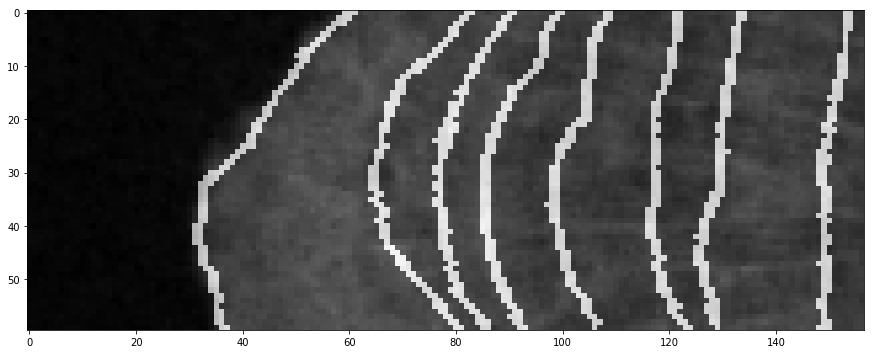

In [20]:
fig, ax = plt.subplots(figsize=(15,15))

ax.imshow(cropped_image, cmap="gray")
ax.imshow(cropped_label, cmap="gray", alpha=0.6)

plt.show()

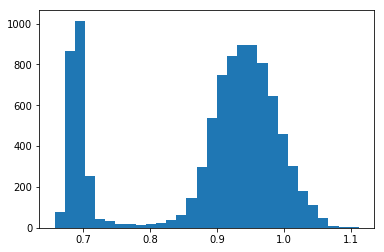

In [21]:
c_image_densities = np.zeros(cropped_image.shape)

for y in range(cropped_image.shape[0]):
    for x in range(cropped_image.shape[1]):
        c_image_densities[y, x] = quad(cropped_image[y, x], *params)

heights, densities, _ = plt.hist(c_image_densities.flatten(), bins=30)

In [22]:
kmeans = KMeans(n_clusters=s.means, random_state=0).fit(c_image_densities.flatten().reshape(-1, 1))
mean_density = np.max(kmeans.cluster_centers_)
print(mean_density)

0.9457481500480216


In [23]:
def hausdorff(shape, boundaries):
    hausdorff = np.zeros(shape)
    for i in range(len(boundaries) - 1):
        for j in boundaries[i]:
            hausdorff[j] = np.inf
            for k in boundaries[i + 1]:
                distance = np.linalg.norm(np.array(j) - np.array(k))
                hausdorff[j] = min(hausdorff[j], distance)
    return hausdorff

In [24]:
num_labels, labels_image = cv.connectedComponents(cropped_label)

for i in range(num_labels):
    if np.sum(labels_image == i) < 10:
        labels_image[labels_image == i] = 0
        cropped_label[labels_image == i] = 0

In [25]:
labels = []

for x in range(labels_image.shape[1]-1, -1, -1):
    for y in range(labels_image.shape[0]):
        label = labels_image[y, x]
        if cropped_label[y, x] != 0 and label not in labels:
            labels.append(label)

print(labels)

boundaries = {}

for i in range(len(labels)):
    boundaries[i] = []

for y in range(labels_image.shape[0]):
    for x in range(labels_image.shape[1]):
        label = labels_image[y, x]
        if label in labels:
            index = labels.index(label)
            boundaries[index].append((y, x))
        
hausdorff_image = hausdorff(cropped_label.shape, boundaries)

[8, 7, 6, 5, 4, 3, 2, 1]


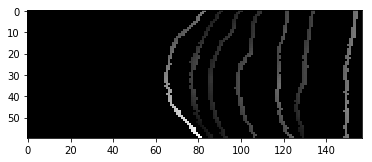

In [26]:
plt.imshow(hausdorff_image, cmap='gray')

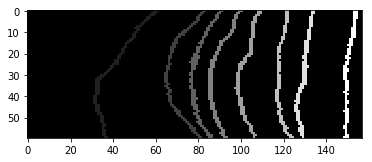

In [27]:
plt.imshow(labels_image, cmap='gray')

In [28]:
averages = np.zeros(len(labels) - 1)
for i in range(len(labels) - 1):
    for j in boundaries[i]:
        averages[i] += + hausdorff_image[j]
    averages[i] /= len(boundaries[i])
print(averages)

[19.62763034  9.4391777  14.50332728 11.16429444  7.36091579  7.91402
 25.37764152]


In [29]:
voxel_size = 0.0762383788824081

linear_extension_mm = np.mean(averages) * 2 * voxel_size

print(linear_extension_mm)

2.0777573675808094


In [30]:
calcification = (linear_extension_mm / 10) * mean_density
print(f"Calcification rate: {calcification:.2f} g cm^(-2) y^(-1)")

Calcification rate: 0.20 g cm^(-2) y^(-1)
